In [1]:
# MESH RELATED FRAMEWORKS
import trimesh
from mesh_to_sdf import sample_sdf_near_surface, mesh_to_sdf

import os
from glob import glob
import io
import PIL.Image, PIL.ImageDraw
import json
import numpy as np
import matplotlib.pylab as plt
import json
import time

from IPython.display import Image, clear_output

c:\users\mykha\appdata\local\programs\python\python38\lib\site-packages\pyglet\libs\win32\__init__.py:326: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


In [2]:
# TEST GPU
# CUDA version tf support (MAX is 11.2)
# https://www.tensorflow.org/install/source#gpu
import tensorflow as tf

print(tf.__version__)
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.10.1
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
#___________Utility functions 

def imshow(a, fmt='jpeg'):
      display(Image(data=imencode(a, fmt)))

def np2pil(a):
    if a.dtype in [np.float32, np.float64]:
        a = np.uint8(np.clip(a, 0, 1)*255)
        
    return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
    a = np.asarray(a)
    
    if isinstance(f, str):
        fmt = f.rsplit('.', 1)[-1].lower()
        if fmt == 'jpg':
            fmt = 'jpeg'
            
        f = open(f, 'wb')
        
    np2pil(a).save(f, fmt, quality=95)

def zoom(img, scale=4):
    img = np.repeat(img, scale, 0)
    img = np.repeat(img, scale, 1)
    return img


def imencode(a, fmt='jpeg'):
    a = np.asarray(a)
    if len(a.shape) == 3 and a.shape[-1] == 4:
        fmt = 'png'
    f = io.BytesIO()
    imwrite(f, a, fmt)
    return f.getvalue()

In [4]:
PROJ_BASE_PATH = os.getcwd()
BASE_DATA_PATH = os.path.join(PROJ_BASE_PATH, "toy_3d_dataset")
BASE_LOGS_PATH = os.path.join(PROJ_BASE_PATH, "logs")
BASE_TENSORBOARD_PATH = os.path.join(PROJ_BASE_PATH, "tensorboard_logs")

dataset_item_paths = glob(os.path.join(BASE_DATA_PATH, "*")) # PathLib

# Sort paths
delum = "\\" # <- windows stuff here!
dataset_item_paths.sort(key =lambda x: int(x.split(delum)[-1].split(".")[0]))

In [5]:
dataset_item_paths

['C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\0.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\1.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\2.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\3.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\4.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\5.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\6.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\7.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\8.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\9.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\10.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\11.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\12.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\\13.obj',
 'C:\\Users\\mykha\\Desktop\\3d_test_task\\toy_3d_dataset\

In [6]:
# MODEL DEFINITION
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Add

# Initialy doesnt work
# https://github.com/titu1994/tf_SIREN
# from tf_siren import SinusodialRepresentationDense
# from tf_siren import SIRENModel
# sdf_model = SIRENModel(units=80, final_units=1, final_activation='sigmoid',
#                    num_layers=5, w0=1.0, w0_initial=30.0)
#tmp = np.random.uniform(low=-2, high=2, size=(1, 3))
#sdf_model(tmp)


# similar tp functional_simple_MLP
# sdf_model = Sequential(
#   [Activation(lambda x:x*50.0)] + 
#   [Dense(80, tf.nn.swish) for i in range(6)] + 
#   [Dense(1,
#       kernel_initializer=tf.initializers.constant(1.0/80),
#       bias_initializer=tf.initializers.constant(-0.1))]
# )

def create_functional_simple_MLP(n_layers, hidden_size=80):
    inputs = Input(shape=(3)) 
    
#     w_init = tf.keras.initializers.GlorotUniform(seed=123) # GlorotNormal has strange efect on off surface loss
    activation = tf.nn.swish #tf.nn.silu

    
    x = Activation(lambda x:x*50.0) (inputs)
    
    x = Dense(hidden_size, activation=activation)(x)

    for _ in range(n_layers-1):
#         Dense residual layer
#         out_x = Dense(hidden_size, activation="relu", kernel_initializer=w_init)(x)
#         added = Add()([x, out_x]) 

        x= Dense(hidden_size,
                 activation=activation)(x)

    outputs = Dense(1, 
                    kernel_initializer=tf.initializers.constant(1.0/hidden_size), 
                    bias_initializer=tf.initializers.constant(-0.1)
                   )(x) # , 

    model = Model(inputs=inputs, outputs=outputs)

    return model


sdf_model = create_functional_simple_MLP(n_layers=6, hidden_size=80)

# Measure time
# tmp = np.random.uniform(low=-2, high=2, size=(1, 3))
# %%timeit 
# sdf_model(tmp)

In [7]:
sdf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 80)                320       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 dense_4 (Dense)             (None, 80)                6480  

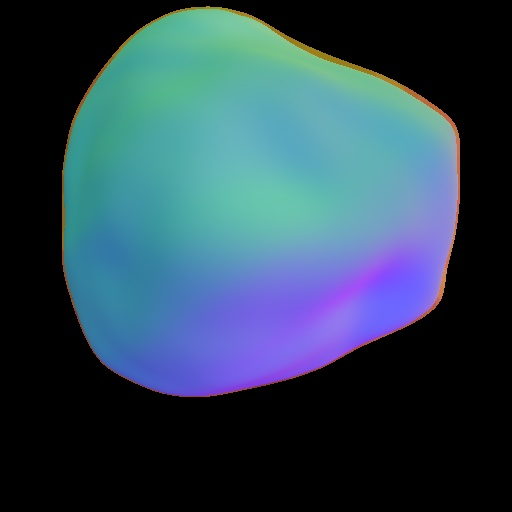

In [8]:
# Important function. Vis uses gradient for calculation of normal
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
        
def grid_inference(sdf, grid):
    grid_shape = grid.shape
    preds = sdf(grid.reshape(grid.shape[0] * grid.shape[0], 3))
    return preds.reshape(grid_shape[0], grid_shape[0], 1)

def viz_val_and_grad(sdf, points):
    with tf.GradientTape() as g:
        g.watch(points)
        dist = grid_inference(sdf, points) #sdf(points) #
        
    point_grad = g.gradient(dist, points)
    return dist, point_grad
    
@tf.function(experimental_compile=True)
def render(sdf, R, offset, fov=0.7, size=512):
  x = tf.linspace(-fov, fov, size)

  x, y = tf.meshgrid(x, -x)
  rays = tf.stack([x, y, -tf.ones_like(x)], -1)

  rays = tf.nn.l2_normalize(rays, -1) @ R
  pos0 = np.float32([[0, 0, 2.5]]) @ R

  pos = pos0+tf.zeros_like(rays)
    
  for i in tf.range(40):
    pred_sdf = grid_inference(sdf, pos) #sdf(pos)
    pos += rays*(pred_sdf - offset) 
    
  dist, normal = viz_val_and_grad(sdf, pos) # Notice what we visualize notmal here (which is have sense because gradient is a direction to init point)

  return normal*0.5+0.5


# Code for debugging purposes (Cannot be used simultaneously with train to avoid weights initialization)
R = np.float32(trimesh.transformations.euler_matrix(0.5, 0.5, 0.0)[:3,:3])

    
rendered_img = render(sdf_model, R, 0.25)
imshow(rendered_img)

In [9]:
def get_verts(mesh, is_normalize=False):
    verts = np.float32(mesh.vertices)
    verts -= verts.mean(0)
    verts /= verts.ptp()*0.4
    return verts

In [10]:
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import manhattan_distances as L1_dist

# NOTE: Every call of this method will generate new random points, which is makes metric inconsistent
# returns dict for store or print

def calculate_metrics(model, 
                      mesh, # Needed only for points generation
                      local_tst_n_points, 
                      global_tst_n_points):
    
    # near surface / local
    test_points, test_sdf = sample_sdf_near_surface(mesh, number_of_points=local_tst_n_points)
    pred_sdf = model(test_points)
    
    local_f1 = f1_score(np.sign(test_sdf), np.sign(pred_sdf), average="macro")    
    
    # all surface / global
    random_points = np.random.uniform(low=-2, high=2, size=(global_tst_n_points, 3))
    test_global_sdfs = mesh_to_sdf(mesh, random_points)
    global_pred_sdf = model(random_points)

    global_f1 = f1_score(np.sign(test_global_sdfs), np.sign(global_pred_sdf), average="macro")
    global_l1 = (global_pred_sdf - test_global_sdfs.reshape(test_global_sdfs.shape[0], 1))
    
#     global_l1 = L1_dist(global_pred_sdf, test_global_sdfs.reshape(test_global_sdfs.shape[0], 1)) # 
    global_l1 = tf.reduce_mean(tf.math.abs(global_l1)).numpy() 
    
    return { "local_f1" : local_f1,
            "global_f1" : global_f1, 
            "global_l1" : float(global_l1.mean()) } # float conversion for json storage

In [13]:
calculate_metrics(sdf_model, 
                      mesh, # Needed only for points generation
                      100, 
                      100)

{'local_f1': 0.0,
 'global_f1': 0.8813559322033897,
 'global_l1': 1.175856590270996}

In [11]:
from tqdm import tqdm

def val_and_grad(sdf, points):
    with tf.GradientTape() as g:
        g.watch(points)
        dist = sdf(points)
        
    point_grad = g.gradient(dist, points)
    return dist, point_grad

def train_one_object(sdf_model,
                     optimizer, 
                     mesh,
                     N_verts_train_points=3000, 
                     steps_per_obj=10000, 
                     local_tst_n_points=1000,
                     global_tst_n_points=1000,
                     show_and_store_render_results=True, # should be divided into two params (show and store) to reduce time for train
                     exp_name="Temp"): # Will be used for results storing (can be object name)
    
    sur_loss_coeff = 1e2 
    
    # TF- runtime (GPU) related functions 
    # https://www.tensorflow.org/guide/function#controlling_retracing
    
    print("Start sample_sdf_near_surface")
    sampled_points, sampled_sdfs = sample_sdf_near_surface(mesh, number_of_points=1000)
    # same way to preprocess vertices
    sampled_points -= sampled_points.mean(0)
    sampled_points /= sampled_points.ptp()*0.4
    
    fig_indexes = np.where(sampled_sdfs < 0)[0]
    fig_sampled_points = sampled_points[np.where(sampled_sdfs < 0)[0]]
    fig_sampled_sdfs = sampled_sdfs[np.where(sampled_sdfs < 0)[0]]
    
    gen_sign_classes = np.array(list(map(lambda x: np.float32(x > 0), sampled_sdfs))).reshape(len(sampled_sdfs), 1)

    print("End sample_sdf_near_surface")
    
    # step - for exponential growth factor
    def loss_f(sdf, points, bg_point_n=500):
        n, dim = points.shape
        all_points = tf.concat([points, tf.random.uniform([bg_point_n, dim], -2.0, 2.0)], 0)

        #Add sampled sdfs to the end of all points
        all_points = tf.concat([all_points, fig_sampled_points], 0)        
        dist, grad = val_and_grad(sdf, all_points)
        
        grad_norm2 = tf.reduce_sum(tf.square(grad), -1)
        grad_loss = tf.reduce_mean(tf.square(grad_norm2-1.0))
        
        surface_loss = tf.reduce_mean(tf.square(dist[:n]))

        offsurface_loss = tf.reduce_mean(tf.exp(-tf.square(dist[n:n+bg_point_n]/0.02))) #n+bg_point_n
        
        sampled_surface_loss = tf.reduce_mean(tf.square(dist[n+bg_point_n:] - fig_sampled_sdfs))
        
        # binary cross entropy for signs in sdf (cast cannot be performed as GPU code probably, slow down training)
#         bce=tf.keras.losses.BinaryCrossentropy(from_logits=True)    
#         pred_sign_classes = tf.map_fn(fn=lambda x: tf.cast(x > 0, tf.float32), elems=dist[n+bg_point_n:])
#         sign_bce = bce(pred_sign_classes, gen_sign_classes)

        #surface_loss,
        return  surface_loss, grad_loss, offsurface_loss, sampled_surface_loss

    @tf.function
    def train_step(points, step, bg_point_n=2000):
        with tf.GradientTape() as g:
            surface_loss, grad_loss, offsurface_loss, sampled_surface_loss = loss_f(sdf_model, 
                                                                                     points,
                                                                                     bg_point_n)
            
            #https://www.desmos.com/calculator/mxqrfchr4x  at 20K ~ 6
#             w_sampled_surface_loss = sampled_surface_loss * 0.1 #tf.exp(step * 0.0001) - 1
            surface_loss *= sur_loss_coeff
    
            total_loss = surface_loss + grad_loss + offsurface_loss #surface_loss 
        
        params = g.watched_variables()
        grads = g.gradient(total_loss, params)
        optimizer.apply_gradients(zip(grads, params))
        
        # Notice we weight losses before (w_ prefix) but return original values here
        return surface_loss, grad_loss, offsurface_loss, sampled_surface_loss
    
    #__________________________________________________________________________________________
    

    R = np.float32(trimesh.transformations.euler_matrix(0.5, 0.5, 0.0)[:3,:3])
    
    verts = get_verts(mesh)
    
    logs_base_path = os.path.join(BASE_LOGS_PATH, exp_name)
    tensorboard_path =  os.path.join(BASE_TENSORBOARD_PATH, exp_name)
    
    images_save_path = os.path.join(logs_base_path, "images")
    metric_save_path = os.path.join(logs_base_path, "metrics") # can be used to store results every epoch
    checkpoint_save_path = os.path.join(logs_base_path, "checkpoint")

    print("Current logs_base_path", logs_base_path)

    for path in [logs_base_path, images_save_path, metric_save_path, logs_base_path, checkpoint_save_path, tensorboard_path]:
        if os.path.isdir(path) is False:
            os.makedirs(path)
    
    writer = tf.summary.create_file_writer(tensorboard_path)
    checkpoint_path =  os.path.join(checkpoint_save_path, "cp.ckpt") 
    
    if N_verts_train_points > len(verts):
        N_verts_train_points = len(verts)
        
    with writer.as_default():         
        for i in tqdm(range(steps_per_obj)):

            points = verts[np.random.choice(len(verts), N_verts_train_points, False)]

            bg_point_n = N_verts_train_points # same number of background points
            surface_loss, grad_loss, offsurface_loss, sampled_surface_loss  = train_step(points, 
                                                                                                tf.convert_to_tensor(i, dtype=tf.float32), 
                                                                                                bg_point_n)

            tf.summary.scalar("surface_loss", surface_loss, step=i)
            tf.summary.scalar("grad_loss", grad_loss, step=i)
            tf.summary.scalar("offsurface_loss", offsurface_loss, step=i)
            tf.summary.scalar("sampled_surface_loss", sampled_surface_loss, step=i)
#             tf.summary.scalar("sign_bce", sign_bce, step=i)
            writer.flush()

            #i % 10**int(np.log10(i+1)) == 0:
            if show_and_store_render_results and i > 100 and i % 10**int(np.log10(i+1)) == 0 or (i > 10000 and i % 1000 == 0): # log scale law for inter-results store
                clear_output(True)

                rendered_img = render(sdf_model, R, 0.0)
                imshow(rendered_img)

                imwrite(os.path.join(images_save_path, f"image{i}.jpeg"), rendered_img)
            
    # Now we store params at the end of training for speed - up (ideally store every epoch)
    result_dict = calculate_metrics(sdf_model, mesh, local_tst_n_points, global_tst_n_points)

    with open(os.path.join(metric_save_path, f"data{i}.json"), 'w') as f:
        json.dump(result_dict, f)

    # store checkpoint at the end of training
    sdf_model.save_weights(checkpoint_path)

In [12]:
#TRAIN ON ONE ELEMENT

sdf_model = create_functional_simple_MLP(n_layers=6, hidden_size=256)

lr0 = 3e-3
# lr_scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#     [3000, 6000, 8000], [lr0, lr0*0.3, lr0*0.1, lr0*0.03])

optimizer = tf.optimizers.Adam(lr0) # no lr_scheduler
        
mesh = trimesh.load(dataset_item_paths[5]) 

train_one_object(sdf_model,
             optimizer, 
             mesh, 
             N_verts_train_points=10000,
             steps_per_obj=10000, 
             exp_name=f"temp{int(time.time())}")

Start sample_sdf_near_surface


KeyboardInterrupt: 

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [100]:
# TRAIN ALL 

# refresh sdf variable
# sdf_model = create_functional_simple_MLP(n_layers=6)


def train_all_objects(dataset_item_paths, exp_name, continue_index=None):
    
    for index, item_path in enumerate(dataset_item_paths):
        # continue training
        if continue_index != None and index < continue_index:
            continue
            
        # recreate model for every object, (I don't recreate model object because it leads to errors inside train step)
        # if I pass new model object to train_step I get error
        # https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
        sdf_model = create_functional_simple_MLP(n_layers=6, hidden_size=80)

        mesh = trimesh.load(item_path) # loads test item
        
        item_exp_name = os.path.join(exp_name, f"item_{index}")
        
        lr0 = 3e-3
        lr_scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            [3000, 6000, 8000], [lr0, lr0*0.3, lr0*0.1, lr0*0.03])
        optimizer = tf.optimizers.Adam(lr_scheduler)
        
        
        start_time = time.time()
        train_one_object(sdf_model,
                     optimizer, 
                     mesh, 
                     N_verts_train_points=10000,
                     steps_per_obj=10000, 
                     exp_name=item_exp_name)
        
        print(time.time() - start_time)

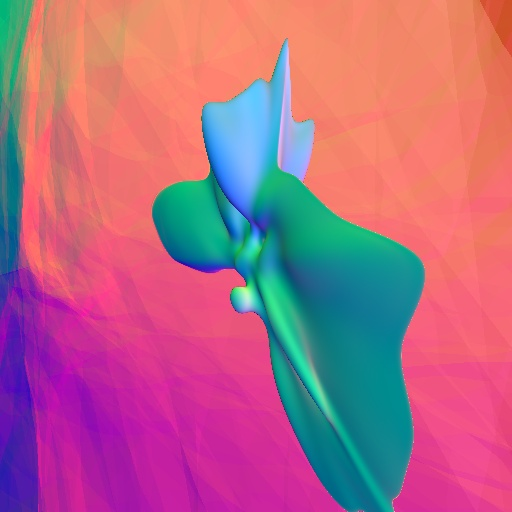

 10%|███████▌                                                                      | 963/10000 [00:40<06:18, 23.87it/s]


KeyboardInterrupt: 

In [101]:
n_train_el = 6

train_all_objects(dataset_item_paths[0:n_train_el], "FINAL_WITH_SWISH_WITHOUT_SHEDULER", 0)

In [ ]:
# RUN RENDER BEFORE INIT WEIGHTS check bike 
# first3_sequential(same_model)